In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow import keras
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
def build_imagenet_model(pretrained_model):

    base_model_out = pretrained_model.output

    # Add flatten layer
    base_model_out = Flatten()(base_model_out)

    # Add 2 dense layers with dropout and batch normalization
    base_model_out = Dense(224, activation='relu')(base_model_out) #kernel_constraint=MaxNorm(3)
    base_model_out = Dropout(0.5)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)

    base_model_out = Dense(112, activation='relu')(base_model_out) #kernel_constraint=MaxNorm(3)
    base_model_out = Dropout(0.25)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)

    # Add final 1 neuron layer, using sigmoid activation for binary classification
    preds = Dense(1, activation='sigmoid')(base_model_out)

    # Instantiate final model and specify input and ouput
    model = Model(inputs = pretrained_model.input, outputs = preds)

    return model

Found 92 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 35s 24s/step - loss: 0.8911 - accuracy: 0.5435 - val_loss: 0.1361 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 22s 8s/step - loss: 0.7690 - accuracy: 0.5435 - val_loss: 0.1629 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 23s 9s/step - loss: 0.6983 - accuracy: 0.5870 - val_loss: 0.3439 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 22s 8s/step - loss: 0.6645 - accuracy: 0.6087 - val_loss: 0.3011 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 23s 8s/step - loss: 0.6667 - accuracy: 0.5761 - val_loss: 0.2994 - val_accuracy: 0.8000 - lr: 1.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


test loss: 0.36915
test acc: 86.00
1/1 [==============================] - 11s 11s/step


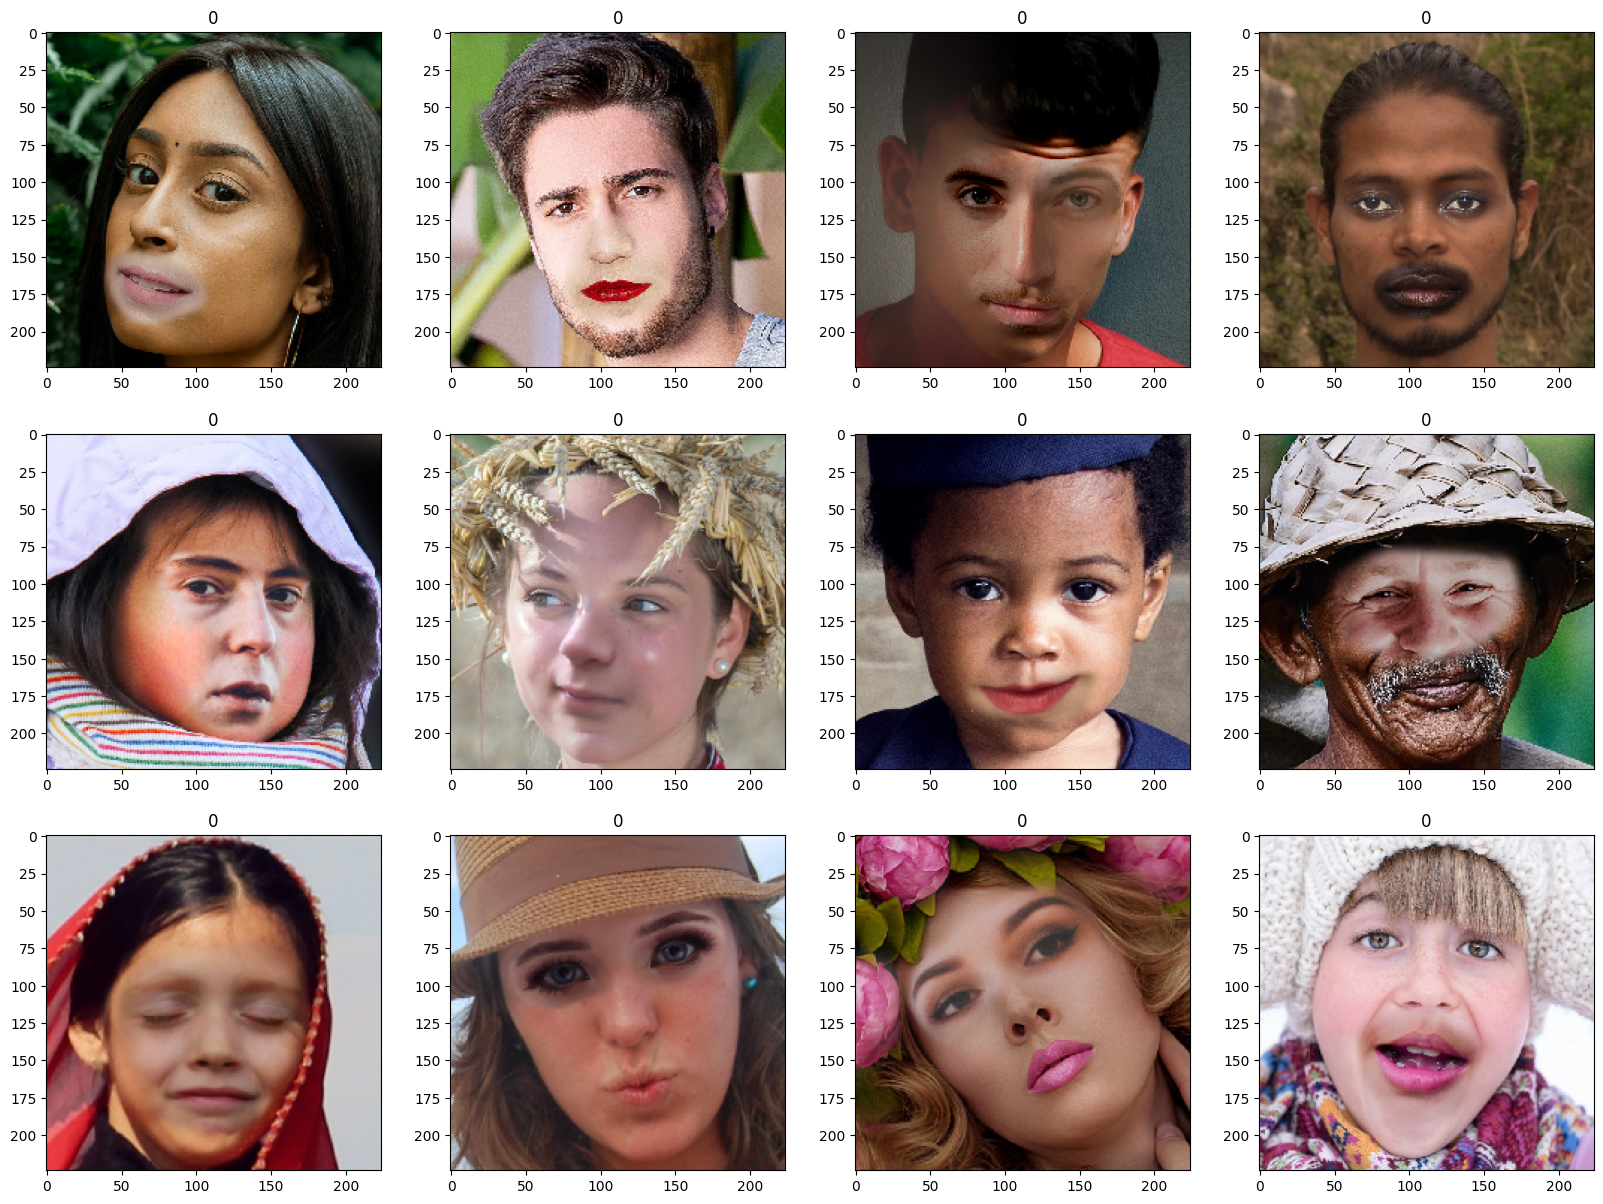

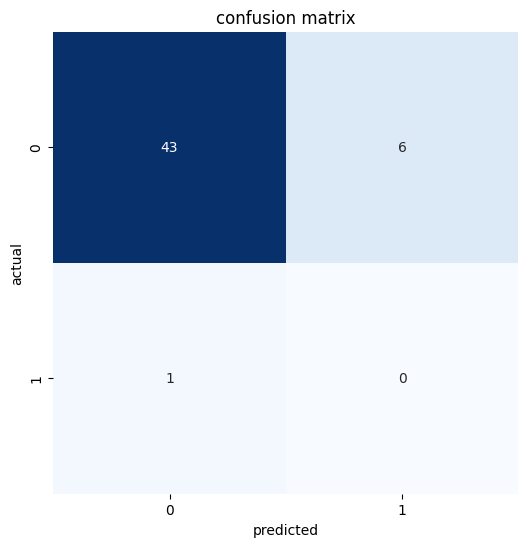

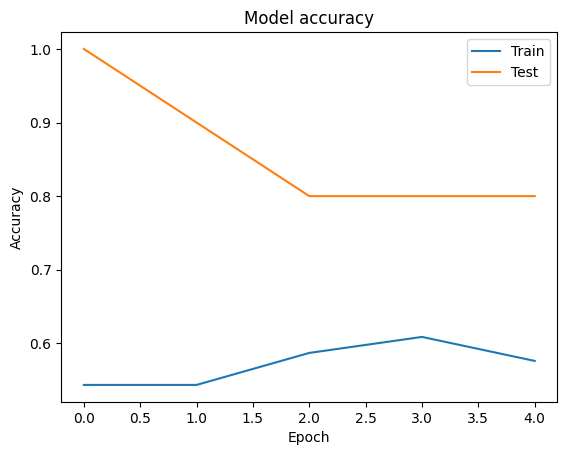

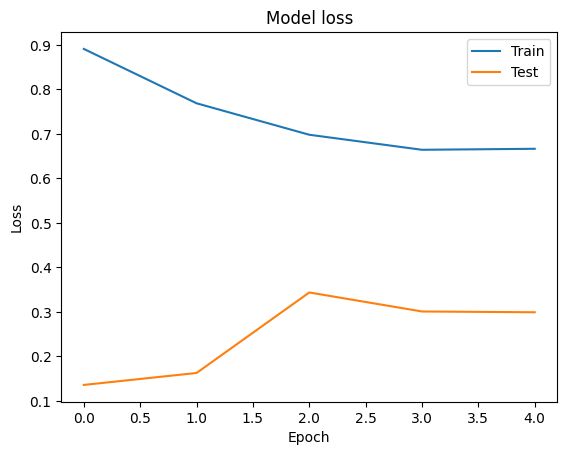

Found 92 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 27s 16s/step - loss: 0.9192 - accuracy: 0.4674 - val_loss: 2.4503e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.5652

In [4]:
import zipfile
import os

zip_path = '/content/sample_data/celeb-df.zip'
extract_path = '/content/samle_data'  # Change this to the desired extraction path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_dir=Path(extract_path)
filepaths= list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df=pd.concat([filepaths,labels],axis=1)

train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False,
    seed= 42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

plt.figure(figsize=(20, 20))
for images, labels in train_images:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("on")
    break

xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224, 3)
)

model = build_imagenet_model(xception)

for layer in model.layers[:len(xception.layers)]:
    layer.trainable = False

model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

EPOCHS=10
epoch_list = list(range(1,EPOCHS+1))

history=model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,

    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )

    ]
)

model.save_weights('my_model_weights.h5')
model.save('140kdfrf_model.h5')

results=model.evaluate(test_images,verbose=0)
print("test loss: {:.5f}".format(results[0]))
print("test acc: {:.2f}".format(results[1]*100))
predictions=(model.predict(test_images)>=0.5).astype(int)
cm=confusion_matrix(test_images.labels,predictions,labels=[0,1])
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.yticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()